In [1]:

# === 0. IMPORTS ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, classification_report, confusion_matrix, brier_score_loss

)


from sklearn.linear_model import LogisticRegressionCV
from sklearn.calibration import CalibratedClassifierCV

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# === 1. CHARGEMENT DES DONNÉES ===

X = pd.read_csv("data/X_selections.csv")
y = pd.read_csv("data/y.csv").squeeze()
y.name = "target"

print(f"Shape X: {X.shape} | Shape y: {y.shape}")
print("Distribution de la cible (train/test avant split):\n",
      y.value_counts(normalize=True).round(3))

# Split stratifié train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

Shape X: (98053, 25) | Shape y: (98053,)
Distribution de la cible (train/test avant split):
 target
0    0.887
1    0.113
Name: proportion, dtype: float64


In [4]:
# === 2. MODELE LOGISTIQUE  ===

logit = LogisticRegression(
             
    solver="liblinear",
    class_weight="balanced",
    max_iter=2000,
    random_state=RANDOM_STATE
)

logit.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42,
                   solver='liblinear')

In [5]:
# === 4. ÉVALUATION SUR TEST ===

proba_test = logit.predict_proba(X_test)[:, 1]

pr_auc = average_precision_score(y_test, proba_test)
roc_auc = roc_auc_score(y_test, proba_test)
brier = brier_score_loss(y_test, proba_test)

print(f"\n=== Performances sur test ===")
print(f"PR-AUC : {pr_auc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Brier  : {brier:.5f}")


=== Performances sur test ===
PR-AUC : 0.1927
ROC-AUC: 0.6328
Brier  : 0.23253


In [6]:
# === 5. métrique ===

prec, rec, thr = precision_recall_curve(y_test, proba_test)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = int(np.nanargmax(f1))
best_thr = thr[min(max(best_idx-1, 0), len(thr)-1)] if len(thr) > 0 else 0.5

print(f"\nSeuil optimal (F1 max): {best_thr:.4f}")

y_pred = (proba_test >= best_thr).astype(int)

print("\n=== Rapport de classification (test) ===")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion (test):\n", cm)


Seuil optimal (F1 max): 0.4894

=== Rapport de classification (test) ===
              precision    recall  f1-score   support

           0      0.917     0.660     0.767     17398
           1      0.166     0.531     0.253      2213

    accuracy                          0.645     19611
   macro avg      0.541     0.595     0.510     19611
weighted avg      0.832     0.645     0.709     19611

Matrice de confusion (test):
 [[11474  5924]
 [ 1037  1176]]


In [7]:
# === 6. INTERPRÉTATION DES COEFFICIENTS ===

coef = pd.Series(logit.coef_.ravel(), index=X_train.columns, name="beta")
odds = np.exp(coef).rename("odds_ratio")

interpret_table = pd.concat([coef, odds], axis=1)
interpret_table["abs_beta"] = interpret_table["beta"].abs()
interpret_table = interpret_table.sort_values("abs_beta", ascending=False)

print("\nTop 20 variables par |β| :")
print(interpret_table[["beta", "odds_ratio"]].head(20))

# Sauvegarde
Path("outputs").mkdir(exist_ok=True)
interpret_table.to_csv("outputs/logreg_interpretation.csv")
pd.DataFrame({"y_true": y_test.values,
              "proba": proba_test,
              "y_pred": y_pred}).to_csv(
    "outputs/test_predictions.csv", index=False
)


Top 20 variables par |β| :
                              beta  odds_ratio
number_inpatient          0.362635    1.437111
race_Asian                0.164972    1.179360
discharge_disposition_id  0.135861    1.145523
nateglinide              -0.109568    0.896222
number_diagnoses          0.097107    1.101978
metformin                -0.089200    0.914662
age_(50-60).1            -0.083484    0.919906
age_(50-60)              -0.083484    0.919906
number_emergency          0.078953    1.082154
time_in_hospital          0.074520    1.077367
num_procedures           -0.072233    0.930314
num_medications           0.054837    1.056368
age_(70-80)               0.039197    1.039975
age_(20-30)              -0.034419    0.966166
race_Caucasian            0.032759    1.033302
age_(30-40)              -0.027602    0.972776
diag_1                   -0.021084    0.979136
admission_source_id      -0.017129    0.983017
gender_Male               0.010995    1.011056
num_lab_procedures        0.0105

<Figure size 600x400 with 0 Axes>

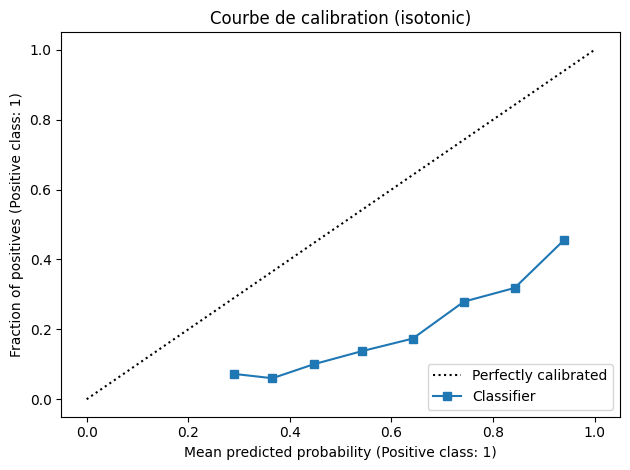

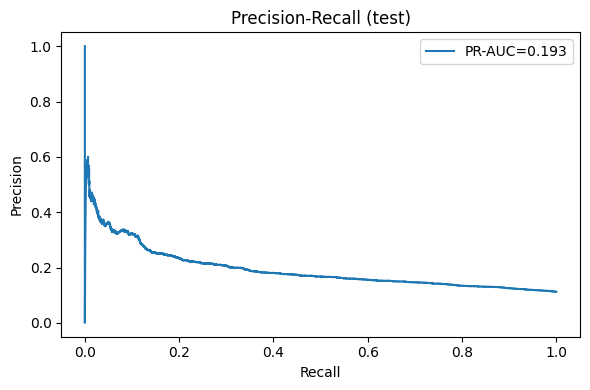

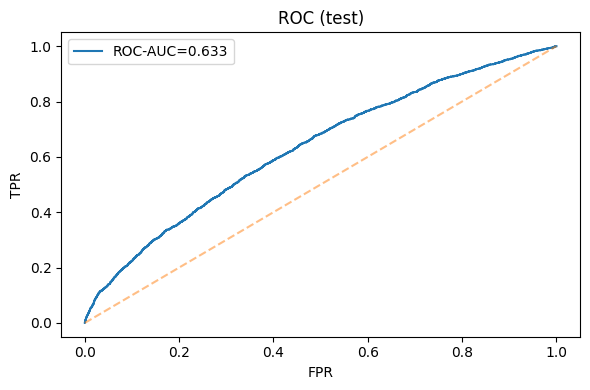

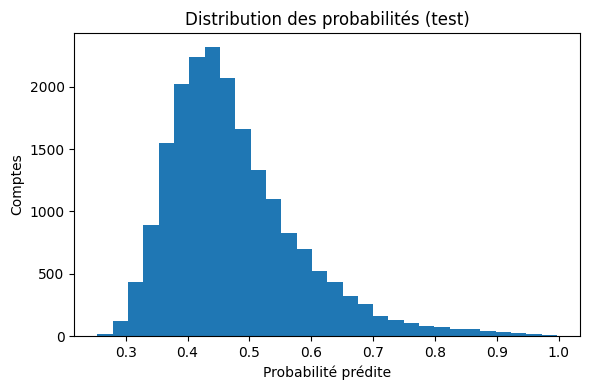

In [8]:
# === 7. VISUALISATIONS ===

# Calibration
plt.figure(figsize=(6,4))
CalibrationDisplay.from_predictions(y_test, proba_test, n_bins=10)
plt.title("Courbe de calibration (isotonic)")
plt.tight_layout()
plt.show()

# PR Curve
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR-AUC={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (test)")
plt.legend()
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--', alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (test)")
plt.legend()
plt.tight_layout()
plt.show()

# Histogramme
plt.figure(figsize=(6,4))
plt.hist(proba_test, bins=30)
plt.xlabel("Probabilité prédite")
plt.ylabel("Comptes")
plt.title("Distribution des probabilités (test)")
plt.tight_layout()
plt.show()


In [14]:
# === 2bis. MODELE LOGISTIQUE AVEC SMOTE ===
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

smote_logit = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="liblinear",
        class_weight="balanced",   # tu peux mettre None si tu veux éviter double correction
        max_iter=2000,
        random_state=RANDOM_STATE
    ))
])

smote_logit.fit(X_train, y_train)

# Prédictions SMOTE
proba_test_sm = smote_logit.predict_proba(X_test)[:, 1]

# Scores SMOTE
pr_auc_sm = average_precision_score(y_test, proba_test_sm)
roc_auc_sm = roc_auc_score(y_test, proba_test_sm)
brier_sm = brier_score_loss(y_test, proba_test_sm)

print("\n=== Performances SMOTE (test) ===")
print(f"PR-AUC : {pr_auc_sm:.4f}")
print(f"ROC-AUC: {roc_auc_sm:.4f}")
print(f"Brier  : {brier_sm:.5f}")

# Seuil optimal SMOTE
prec_sm, rec_sm, thr_sm = precision_recall_curve(y_test, proba_test_sm)
f1_sm = 2 * prec_sm * rec_sm / (prec_sm + rec_sm + 1e-12)
best_idx_sm = int(np.nanargmax(f1_sm))
best_thr_sm = thr_sm[min(max(best_idx_sm-1, 0), len(thr_sm)-1)] if len(thr_sm) > 0 else 0.5

print(f"\nSeuil optimal SMOTE (F1 max): {best_thr_sm:.4f}")

y_pred_sm = (proba_test_sm >= best_thr_sm).astype(int)

print("\n=== Rapport de classification SMOTE (test) ===")
print(classification_report(y_test, y_pred_sm, digits=3))



=== Performances SMOTE (test) ===
PR-AUC : 0.1805
ROC-AUC: 0.6045
Brier  : 0.23310

Seuil optimal SMOTE (F1 max): 0.5589

=== Rapport de classification SMOTE (test) ===
              precision    recall  f1-score   support

           0      0.908     0.775     0.836     17398
           1      0.177     0.380     0.242      2213

    accuracy                          0.731     19611
   macro avg      0.542     0.578     0.539     19611
weighted avg      0.825     0.731     0.769     19611



In [13]:
print("\n=== COMPARAISON LOGIT vs LOGIT+SMOTE ===")

df_comp = pd.DataFrame({
    "Metric": ["ROC-AUC", "PR-AUC", "Brier"],
    "Logit": [roc_auc, pr_auc, brier],
    "SMOTE+Logit": [roc_auc_sm, pr_auc_sm, brier_sm]
})

print(df_comp)



=== COMPARAISON LOGIT vs LOGIT+SMOTE ===
    Metric     Logit  SMOTE+Logit
0  ROC-AUC  0.632834     0.604522
1   PR-AUC  0.192747     0.180514
2    Brier  0.232530     0.233096


In [ ]:
# Abre de decision (on peut aussi fare sans pré-selection mais j'ai testé et ce n'est pas meilleur)

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

# === MODELE DE BASE ===
dt = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=42
)

# === PETITE GRILLE OPTIMISÉE (rapide + efficace) ===
dt_params = {
    "max_depth": [3, 5, 7, 10, None],      
    "min_samples_leaf": [20, 50, 100],    
    "min_samples_split": [2, 5, 10]       
}

dt_cv = GridSearchCV(
    estimator=dt,
    param_grid=dt_params,
    scoring="average_precision",   # PR-AUC = dynamique pour classes déséquilibrées
    cv=5,
    n_jobs=-1,
    verbose=0
)

# Entraînement
dt_cv.fit(X_train, y_train)

print("Meilleurs paramètres (Decision Tree) :")
print(dt_cv.best_params_)

dt_model = dt_cv.best_estimator_


Meilleurs paramètres (Decision Tree) :
{'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 2}


In [28]:
# === 4bis. ÉVALUATION ARBRE DE DÉCISION SUR TEST ===

proba_test_tree = dt_model.predict_proba(X_test)[:, 1]

pr_auc_tree = average_precision_score(y_test, proba_test_tree)
roc_auc_tree = roc_auc_score(y_test, proba_test_tree)
brier_tree = brier_score_loss(y_test, proba_test_tree)

print("\n=== Performances ARBRE sur test ===")
print(f"PR-AUC : {pr_auc_tree:.4f}")
print(f"ROC-AUC: {roc_auc_tree:.4f}")
print(f"Brier  : {brier_tree:.5f}")

# Seuil optimal comme pour le logit : F1 max
prec_tree, rec_tree, thr_tree = precision_recall_curve(y_test, proba_test_tree)
f1_tree = 2 * prec_tree * rec_tree / (prec_tree + rec_tree + 1e-12)
best_idx_tree = int(np.nanargmax(f1_tree))
best_thr_tree = thr_tree[min(max(best_idx_tree-1, 0), len(thr_tree)-1)] if len(thr_tree) > 0 else 0.5

print(f"\nSeuil optimal ARBRE (F1 max): {best_thr_tree:.4f}")

y_pred_tree = (proba_test_tree >= best_thr_tree).astype(int)

print("\n=== Rapport de classification ARBRE (test) ===")
print(classification_report(y_test, y_pred_tree, digits=3))

cm_tree = confusion_matrix(y_test, y_pred_tree)
print("Matrice de confusion ARBRE (test):\n", cm_tree)



=== Performances ARBRE sur test ===
PR-AUC : 0.1934
ROC-AUC: 0.6476
Brier  : 0.22745

Seuil optimal ARBRE (F1 max): 0.5512

=== Rapport de classification ARBRE (test) ===
              precision    recall  f1-score   support

           0      0.915     0.755     0.827     17398
           1      0.188     0.446     0.264      2213

    accuracy                          0.720     19611
   macro avg      0.551     0.600     0.546     19611
weighted avg      0.833     0.720     0.764     19611

Matrice de confusion ARBRE (test):
 [[13141  4257]
 [ 1227   986]]


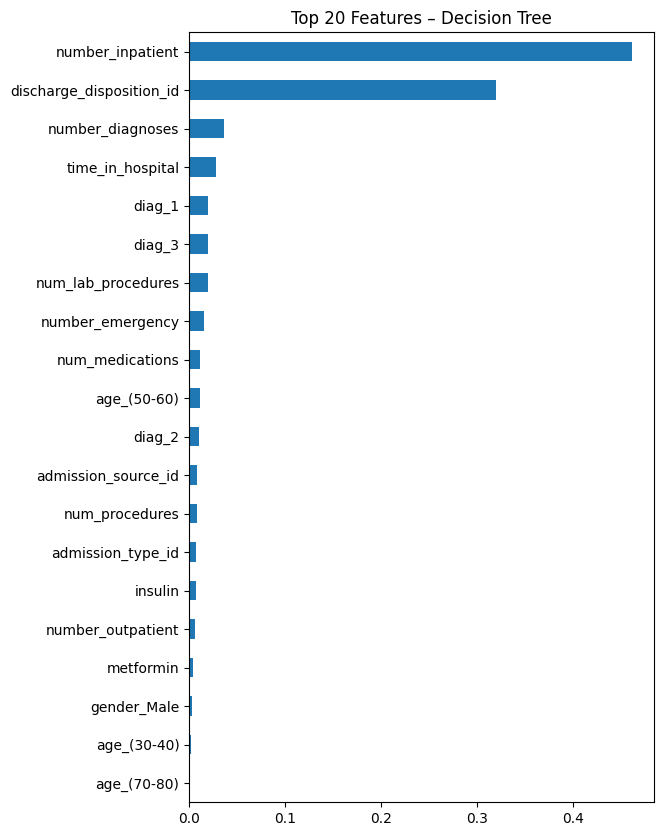

In [32]:
feat_imp = pd.Series(dt_model.feature_importances_, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)

plt.figure(figsize=(6,10))
feat_imp.head(20).plot(kind="barh")
plt.title("Top 20 Features – Decision Tree")
plt.gca().invert_yaxis()
plt.show()


In [29]:
# === 9bis. COMPARAISON LOGIT vs SMOTE+LOGIT vs ARBRE ===

df_comp = pd.DataFrame({
    "Metric": ["ROC-AUC", "PR-AUC", "Brier"],
    "Logit": [roc_auc, pr_auc, brier],
    "SMOTE+Logit": [roc_auc_sm, pr_auc_sm, brier_sm],
    "DecisionTree": [roc_auc_tree, pr_auc_tree, brier_tree]
})

print("\n=== COMPARAISON DES MODELES ===")
print(df_comp)



=== COMPARAISON DES MODELES ===
    Metric     Logit  SMOTE+Logit  DecisionTree
0  ROC-AUC  0.632834     0.604522      0.647563
1   PR-AUC  0.192747     0.180514      0.193372
2    Brier  0.232530     0.233096      0.227447


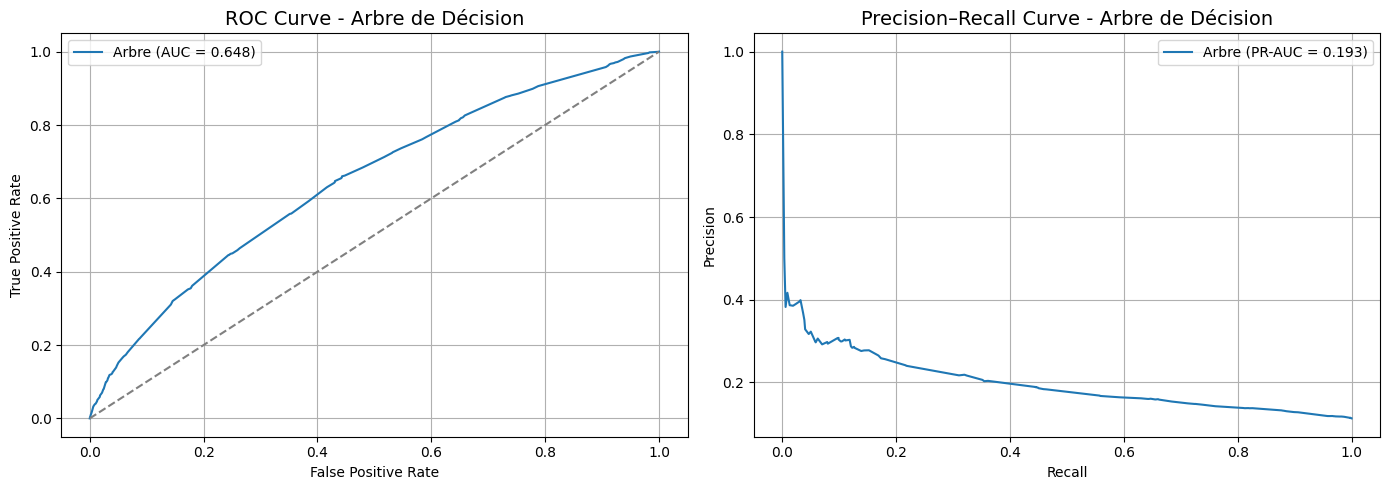

In [30]:
# === PLOTS (ROC & PR) POUR L’ARBRE DE DÉCISION ===

from sklearn.metrics import roc_curve, precision_recall_curve

# Courbes
fpr_tree, tpr_tree, _ = roc_curve(y_test, proba_test_tree)
prec_tree, rec_tree, _ = precision_recall_curve(y_test, proba_test_tree)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# ----------------------------------------------
# 1) ROC Curve
# ----------------------------------------------
ax[0].plot(fpr_tree, tpr_tree, label=f"Arbre (AUC = {roc_auc_tree:.3f})")
ax[0].plot([0, 1], [0, 1], "--", color="grey")
ax[0].set_title("ROC Curve - Arbre de Décision", fontsize=14)
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].grid(True)
ax[0].legend()

# ----------------------------------------------
# 2) Precision–Recall Curve
# ----------------------------------------------
ax[1].plot(rec_tree, prec_tree, label=f"Arbre (PR-AUC = {pr_auc_tree:.3f})")
ax[1].set_title("Precision–Recall Curve - Arbre de Décision", fontsize=14)
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()


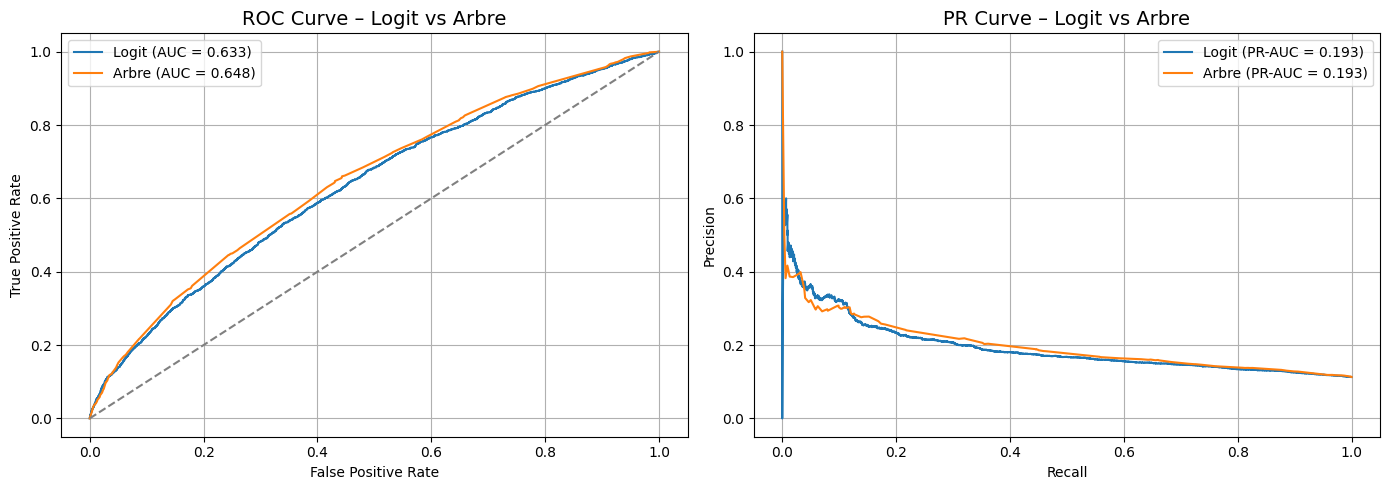

In [31]:
# === COURBES COMPARATIVES LOGIT vs ARBRE ===

# Courbes logit (déjà calculées normalement)
fpr_log, tpr_log, _ = roc_curve(y_test, proba_test)
prec_log, rec_log, _ = precision_recall_curve(y_test, proba_test)

# Courbes arbre
fpr_tree, tpr_tree, _ = roc_curve(y_test, proba_test_tree)
prec_tree, rec_tree, _ = precision_recall_curve(y_test, proba_test_tree)

fig, ax = plt.subplots(1, 2, figsize=(14,5))

# -----------------------------------------------------
# 1) ROC CURVE COMPARATIVE
# -----------------------------------------------------
ax[0].plot(fpr_log, tpr_log, label=f"Logit (AUC = {roc_auc:.3f})")
ax[0].plot(fpr_tree, tpr_tree, label=f"Arbre (AUC = {roc_auc_tree:.3f})")
ax[0].plot([0,1],[0,1],"--", color="grey")

ax[0].set_title("ROC Curve – Logit vs Arbre", fontsize=14)
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].grid(True)
ax[0].legend()

# -----------------------------------------------------
# 2) PRECISION–RECALL CURVE COMPARATIVE
# -----------------------------------------------------
ax[1].plot(rec_log, prec_log, label=f"Logit (PR-AUC = {pr_auc:.3f})")
ax[1].plot(rec_tree, prec_tree, label=f"Arbre (PR-AUC = {pr_auc_tree:.3f})")

ax[1].set_title("PR Curve – Logit vs Arbre", fontsize=14)
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(
    n_estimators=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Grille optimisée : petite mais suffisante
rf_params = {
    "max_depth": [5, 10, 20, None],
    "min_samples_leaf": [10, 30, 50],
    "max_features": ["sqrt", "log2", None]  # None = toutes les features
}

rf_cv = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    scoring="average_precision",   # PR-AUC
    cv=5,
    n_jobs=-1,
    verbose=0
)

rf_cv.fit(X_train, y_train)

print("Meilleurs paramètres (Random Forest) :")
print(rf_cv.best_params_)

rf_model = rf_cv.best_estimator_


Meilleurs paramètres (Random Forest) :
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 50}


In [42]:
# === 4. ÉVALUATION COMPLETE RANDOM FOREST SUR TEST ===

from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    precision_recall_curve, classification_report, confusion_matrix
)

# Probabilités et prédictions
proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Métriques probabilistes
roc_auc_rf = roc_auc_score(y_test, proba_rf)
pr_auc_rf = average_precision_score(y_test, proba_rf)
brier_rf = brier_score_loss(y_test, proba_rf)

print("\n=== Performances RANDOM FOREST sur test ===")
print(f"ROC-AUC : {roc_auc_rf:.4f}")
print(f"PR-AUC  : {pr_auc_rf:.4f}")
print(f"Brier   : {brier_rf:.5f}")

# -------------------------------------------------------------------
# === Seuil optimal basé sur le F1-score ===
# -------------------------------------------------------------------
prec_rf, rec_rf, thr_rf = precision_recall_curve(y_test, proba_rf)
f1_rf_curve = 2 * prec_rf * rec_rf / (prec_rf + rec_rf + 1e-12)

best_idx_rf = int(np.nanargmax(f1_rf_curve))
best_thr_rf = thr_rf[min(max(best_idx_rf-1, 0), len(thr_rf)-1)] if len(thr_rf) > 0 else 0.5

print(f"\nSeuil optimal RF (F1 max): {best_thr_rf:.4f}")

# Prédictions binaires
y_pred_rf = (proba_rf >= best_thr_rf).astype(int)

# F1 pos / F1 neg / Harmonic F1
f1_pos_rf = f1_score(y_test, y_pred_rf)
f1_neg_rf = f1_score(1 - y_test, 1 - y_pred_rf)
harm_rf = (2 * f1_pos_rf * f1_neg_rf) / (f1_pos_rf + f1_neg_rf + 1e-12)

print("\n=== F1 Scores ===")
print(f"F1_POS       : {f1_pos_rf:.4f}")
print(f"F1_NEG       : {f1_neg_rf:.4f}")
print(f"Harmonic F1  : {harm_rf:.4f}")

# -------------------------------------------------------------------
# === Rapport complet de classification ===
# -------------------------------------------------------------------
print("\n=== Rapport de classification RANDOM FOREST (test) ===")
print(classification_report(y_test, y_pred_rf, digits=3))

# Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Matrice de confusion RF (test):\n", cm_rf)



=== Performances RANDOM FOREST sur test ===
ROC-AUC : 0.6520
PR-AUC  : 0.2036
Brier   : 0.21098

Seuil optimal RF (F1 max): 0.5345

=== F1 Scores ===
F1_POS       : 0.2676
F1_NEG       : 0.8276
Harmonic F1  : 0.4045

=== Rapport de classification RANDOM FOREST (test) ===
              precision    recall  f1-score   support

           0      0.915     0.755     0.828     17398
           1      0.190     0.452     0.268      2213

    accuracy                          0.721     19611
   macro avg      0.553     0.604     0.548     19611
weighted avg      0.834     0.721     0.764     19611

Matrice de confusion RF (test):
 [[13138  4260]
 [ 1213  1000]]


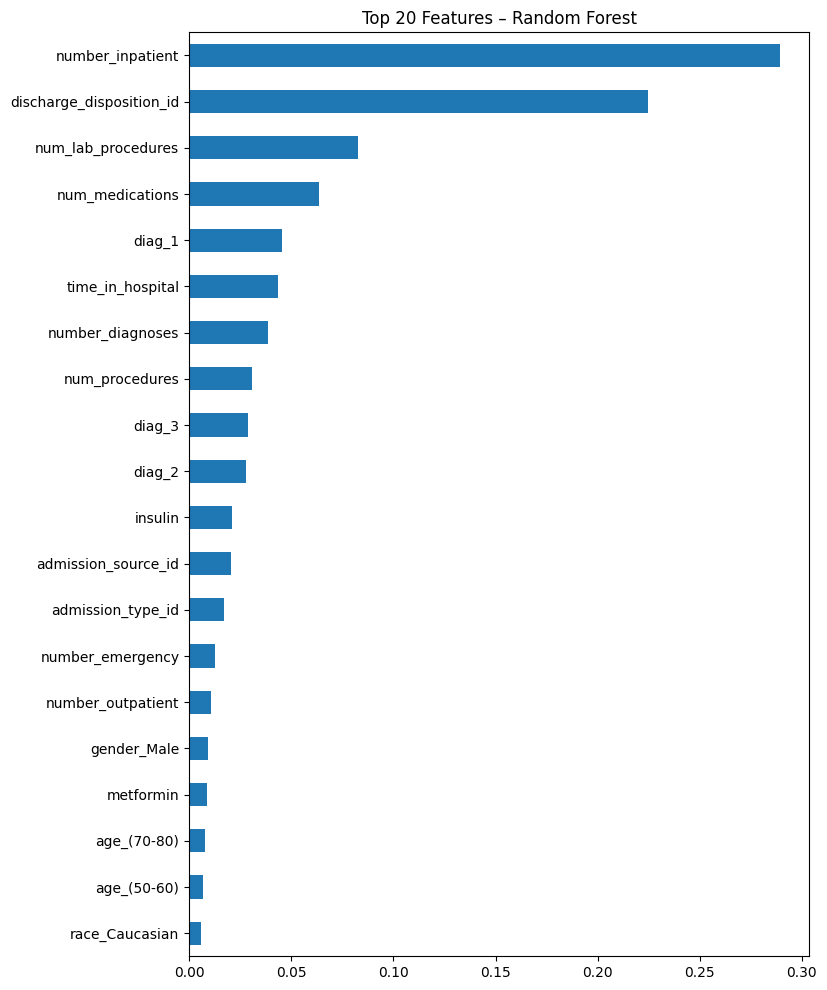

In [43]:
import pandas as pd

fi_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns)
fi_rf = fi_rf.sort_values(ascending=False)

plt.figure(figsize=(8,12))
fi_rf.head(20).plot(kind="barh")
plt.title("Top 20 Features – Random Forest")
plt.gca().invert_yaxis()
plt.show()


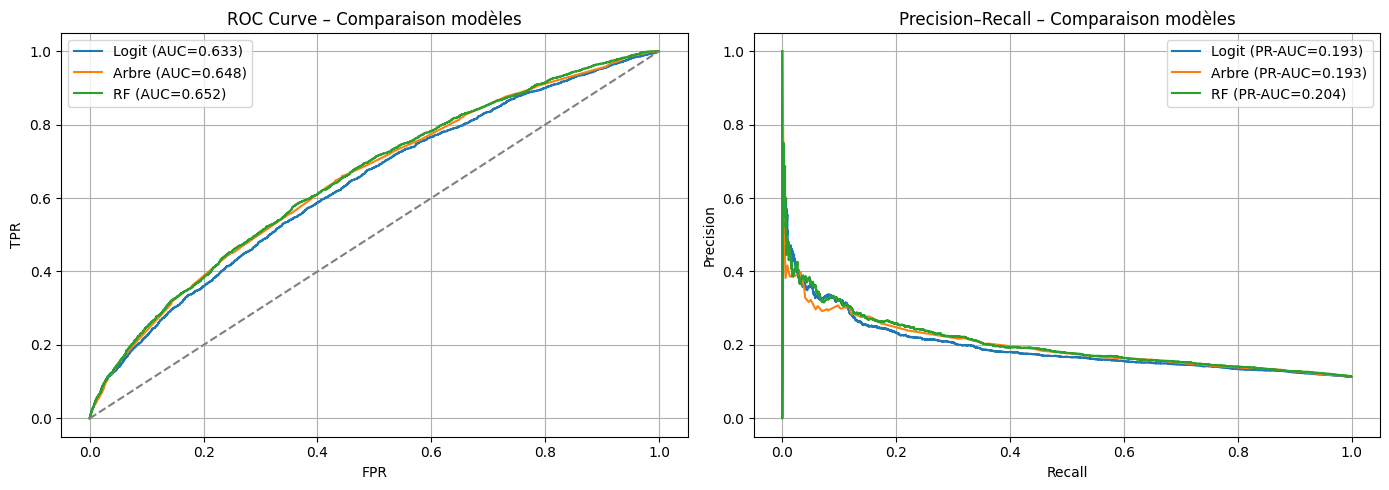

In [46]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Logit
fpr_log, tpr_log, _ = roc_curve(y_test, proba_test)
prec_log, rec_log, _ = precision_recall_curve(y_test, proba_test)

# Arbre
fpr_dt, tpr_dt, _ = roc_curve(y_test, proba_dt)
prec_dt, rec_dt, _ = precision_recall_curve(y_test, proba_dt)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, proba_rf)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
ax[0].plot(fpr_log, tpr_log, label=f"Logit (AUC={roc_auc:.3f})")
ax[0].plot(fpr_dt, tpr_dt, label=f"Arbre (AUC={roc_dt:.3f})")
ax[0].plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_rf:.3f})")
ax[0].plot([0,1],[0,1],"--", color="grey")
ax[0].set_title("ROC Curve – Comparaison modèles")
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")
ax[0].grid(True)
ax[0].legend()

# PR curves
ax[1].plot(rec_log, prec_log, label=f"Logit (PR-AUC={pr_auc:.3f})")
ax[1].plot(rec_dt, prec_dt, label=f"Arbre (PR-AUC={pr_auc_tree:.3f})")
ax[1].plot(rec_rf, prec_rf, label=f"RF (PR-AUC={pr_auc_rf:.3f})")
ax[1].set_title("Precision–Recall – Comparaison modèles")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
##### Modèle ensembliste 

In [ ]:
# Catboost

Colonnes catégorielles détectées : []
